# Generation Using Idyoms

In [1]:
using DataFrames, Plots, Random
using Chakra
include("src/Idyoms.jl")
using Main.Idyoms

## Load Melch

In [2]:
using Melch
Melch.__INIT__("/Users/nick/Dropbox/MelchData")

## Select Nova Dataset

In [3]:
nova = fnd(Melch.id(0),Melch)
nova.description

"Songs and ballads from Nova Scotia, Canada."

## Generate Sequences

In [4]:
melodies = pts(nova)
sequences = [sequence(pts(mel,Melch),Melch) for mel in melodies];

In [5]:
dump(sequences[1][1])

Melch.Event
  id: Melch.EventId
    dataset: Int64 0
    melody: Int64 1
    event: Int64 1
  ONSET: Int64 0
  DELTAST: Int64 0
  BIOI: Int64 1
  DUR: Int64 24
  CPITCH: Int64 65
  MPITCH: Int64 38
  ACCIDENTAL: Int64 0
  KEYSIG: Int64 -1
  MODE: Int64 0
  BARLENGTH: Int64 48
  PULSES: Int64 2
  PHRASE: Int64 1
  VOICE: Int64 1
  ORNAMENT: Int64 0
  COMMA: Int64 0
  VERTINT12: Chakra.None Chakra.None()
  ARTICULATION: Int64 0
  DYN: Chakra.None Chakra.None()


## Define Viewpoints

In [6]:
CPITCH = vp(Melch.CPITCH)
DUR = vp(Melch.DUR)
CPITCH_X_DUR = link(CPITCH,DUR)

Chakra.LinkedViewpoint{Tuple{Int64, Int64}}(Viewpoint[Chakra.AtomicViewpoint{Int64}(Melch.Attribute{:CPITCH, Int64}(), Type[Int64]), Chakra.AtomicViewpoint{Int64}(Melch.Attribute{:DUR, Int64}(), Type[Int64])], DataType[Int64, Int64])

## Generate Views

In [7]:
p_p = [View(seq,CPITCH,CPITCH) for seq in sequences];
d_d = [View(seq,DUR,DUR) for seq in sequences];
p_d = [View(seq,CPITCH,DUR) for seq in sequences];
d_p = [View(seq,DUR,CPITCH) for seq in sequences];
pxd_pxd = [View(seq,CPITCH_X_DUR,CPITCH_X_DUR) for seq in sequences];

## Set Parameters

In [8]:
o = Bounded(5) # order bound
b = Interpolated() # smoothing technique
e = A() # escape method
u = true # update exclusion

true

## Generate Models

In [9]:
p_p_tally, p_seen = Idyoms.train(p_p,o);
d_d_tally, d_seen = Idyoms.train(d_d,o);
p_d_tally, d_seen = Idyoms.train(p_d,o);
d_p_tally, p_seen = Idyoms.train(d_p,o);
pxd_pxd_tally, pxd_seen = Idyoms.train(pxd_pxd,o);

## Use models to generate new sequences

In [10]:
preds, seq = Idyoms.generate_sequence(100,pxd_pxd_tally,pxd_seen,pxd_seen,b,e,u,o);

## Display Sequence

In [11]:
Idyoms.mean_infcontent(preds)

2.4669555056278205

In [12]:
df = Idyoms.todataframe(1,preds)

Row,SeqID,EventID,Symbol,Order,Prob,IC,H
,Int64,Int64,Tuple…,Int64,Float64,Float64,Float64
1,1,1,"(58, 12)",0,0.00825783,6.92002,5.76473
2,1,2,"(63, 12)",1,0.152019,2.71768,3.95201
3,1,3,"(63, 12)",2,0.493631,1.01849,2.09102
4,1,4,"(60, 24)",3,0.272216,1.87718,2.69074
5,1,5,"(58, 12)",4,0.726085,0.46179,1.67638
6,1,6,"(58, 12)",5,0.751723,0.411727,1.52949
7,1,7,"(63, 12)",5,0.704482,0.505365,1.71233
8,1,8,"(65, 36)",1,0.00233248,8.74392,1.26517
9,1,9,"(58, 12)",2,0.1223,3.03151,2.98376


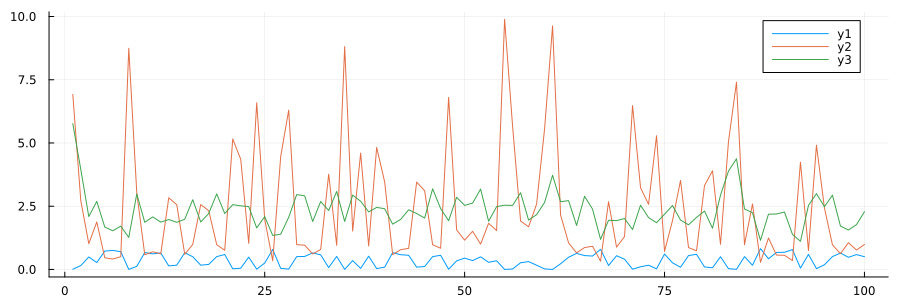

In [13]:
plot(df.Prob)
plot!(df.IC)
plot!(df.H)
plot!(size=(900,300))

In [14]:
using MIDI, Dates
function generatemidifile(xs::Vector{Tuple{Int,Int}},name::String)
    tpq = 960
    notes = Note[]
    pos = 0
    for pair in xs
        pitch = pair[1]
        velocity = 100
        dur = Int(tpq*pair[2]/24)
        
        note = Note(pitch,100,pos,dur)
        
        push!(notes,note)
        pos+=dur
    end
    track = MIDITrack()
    addnotes!(track, notes)
    
    midi = MIDIFile(0, tpq, [track])
    cd(@__DIR__)
    save(name, midi)
end

generatemidifile (generic function with 1 method)

In [15]:
generatemidifile(seq,"example.mid")

MIDIFile (format=0, tpq=960) with 1 tracks